### Softmax(), sigmoid() 함수 <hr> 
- sigmoid() : y=wx+b 결과 1개 전달 받음 ===> 반환 : 0.0 ~ 1.0 사이 값으로 변환 => 이진분류
- softmax() : y=wx+b 결과 n개 전달 받음 => 반환 : 여러 개의 결과 값의 합이 1.0이 되도록 변환 => 다중 분류 

In [42]:
# 모듈 로딩
import torch                    # 토치 기본 모듈. Tensor 및 기본 함수들.
import torch.nn.functional as F # 파이토치 인공신경망 관련 함수들

In [43]:
# 임의의 데이터 생성
data1 = torch.tensor([1,2,1,1,2])
data1.shape

torch.Size([5])

In [44]:
F.sigmoid(data1) #자동계산 해줬는데 이게 뭔지 모르겠다.

tensor([0.7311, 0.8808, 0.7311, 0.7311, 0.8808])

- softmax()

In [45]:
# softmax(
#     input: Tensor,
#     dim: int | None = ...,
#     _stacklevel: int = ...,
#     dtype: _dtype | None = ...
# ) -> Tensor

In [46]:
# 임의의 데이터
data2 = data1.unsqueeze(dim=0) # 1행 5열
data2.shape, data2

(torch.Size([1, 5]), tensor([[1, 2, 1, 1, 2]]))

In [47]:
input = torch.randn(2,3)
input

tensor([[ 0.0585,  0.4660, -1.0953],
        [-0.8427, -1.1074, -0.1886]])

In [48]:
output = F.softmax(input)
output

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_30012\3352805213.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(input)


tensor([[0.3548, 0.5333, 0.1119],
        [0.2709, 0.2079, 0.5211]])

In [49]:
output.sum(dim=1) # 각 행의 합

tensor([1., 1.])

In [50]:
output.max(dim=1)[1][0].item()

1

In [51]:
output.argmax(dim=1)

tensor([1, 2])

[1] 모듈 로딩 및 데이터 준비 <hr>
scikit-learn에서 데이터 다운 및 확인

In [52]:
# 모듈 로딩
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

import torch
import torch.nn as nn           # LinearRegression 기능의 클래스 linear
import torch.nn.functional as F # 손실함수
import torch.optim as optim     # 경사하강법 기반의 최적화 관련 모듈

In [53]:
# 데이터 준비
fashion_db = 'fashion-mnist'

fashion_data = fetch_openml(name=fashion_db, parser='auto') #as_frame = False
# type(fashion_data) => 분명 frame으로 들어온다셨는데 왜 저는 bunch로 들어올까요...?

In [54]:
feature = fashion_data['data']
target = fashion_data['target']

In [55]:
# 피처와 타겟 개수 확인
print(f'FEATURE => {feature.shape}, {feature.ndim}D')
print(f'TARGET => {target.shape}, {target.ndim}D')

FEATURE => (70000, 784), 2D
TARGET => (70000,), 1D


In [56]:
# 분류 확인 
print(f'FEATURE => {fashion_data["feature_names"]}')
print(f'TARGET => {fashion_data["target_names"]}')
print(f'CATEGORIES => {fashion_data["categories"]}') # dataframe일 때는 None으로 출력 / Numpy 일 때는 출력값 有 뭔진 모르겠지만...
print(f'CATEGORIES => {target.unique()}') 

FEATURE => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel9

[2] 데이터 가공 및 전처리 <hr>
- 결측치 / 중복 / 이상치 => 없음
- 다중 분류 ▶ 이진 분류 변환 => 타겟 변환
- 표준화 => 이미지 동일 크기 및 색상 채널 : 동일 크기(28*28)와 채널(흑백1) 
- 정규화 => 피처 정규화 / 타겟 정규화

In [57]:
# [2-1] 다중 분류 ▶ 이진 분류 변환 => 타겟 변환
target = target == '0' # 0만 True 나머지 False

target.unique()

array([False,  True])

In [60]:
# [2-2] 정규화 => 피처  :785개 색상값 즉 0~255 범위 값

normFeature=feature/255. # 정수 / 실수 ==> 실수로 형변환하여 나눗셈 실행.
normFeature.head(2)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.0,0.0,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# [2-2] 정규화 => 타겟 : One-Hot 인코딩으로 변환.
pd.get_dummies(target)

,False,True
0,True,False
1,False,True
2,False,True
3,True,False
4,False,True
...,...,...
69995,True,False
69996,True,False
69997,True,False
69998,True,False


In [67]:
from sklearn.preprocessing import OneHotEncoder
targetDF=target.to_frame()
print(targetDF.shape)


(70000, 1)


c:\ProgramData\anaconda3\envs\Torch_py38\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[array([False]),
 array([ True]),
 array([ True]),
 array([False]),
 array([ True]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([ True]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([ True]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([ True]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([ True]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([ True]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]),
 array([False]

In [77]:
# ohEncoder.transform([target]).toarray() # 압축해서 받은 걸 풀어서 받으려고 toarray를 쓴것.
# => <1x70000 sparse matrix of type '<class 'numpy.float64'>' with 70000 stored elements in Compressed Sparse Row format>
ohEncoder = OneHotEncoder() # sparse =True =--> 압축시켜서 줌.
ohEncoder.fit([target])
ohEncoder.transform([target]).toarray()


array([[1., 1., 1., ..., 1., 1., 1.]])

In [74]:
#sparse_output=False : ndarray type으로 반환
ohEncoder = OneHotEncoder(sparse_output=False) # sparse =True =--> 압축시켜서 줌.
ohEncoder.fit(targetDF)
ohEncoder.categories_

[array([False,  True])]

In [75]:
norm_target = ohEncoder.transform(targetDF)
norm_target.shape, norm_target.ndim

((70000, 2), 2)

[3] 학습 준비 <hr>
- 텐서화
- 데이터셋 준비 : 훈련용, 테스트용
- 학습 방법 : 지도 학습 ( 이진 분류 ) => Linear 클래스 + Sigmoid 함수
- 최적화 방법 : 경사하강법 기반 => adam, SDG    
- 손실 함수 : 이진분류 손실 계산 함수 => binary_cross_entropy

In [88]:
# 데이터셋 준비 : 6만 개 훈련, 1만 개 테스트.
limit = 60000
train = normFeature.iloc[:limit]
test = normFeature.iloc[limit:]
ytrain = target.iloc[:limit]
ytest = target.iloc[limit:]

In [89]:
print(f'train : {train.shape}, {train.ndim}D')
print(f'test : {test.shape}, {test.ndim}D')
print(f'ytrain : {ytrain.shape}, {ytrain.ndim}D')
print(f'ytest : {ytest.shape}, {ytest.ndim}D')

train : (60000, 784), 2D
test : (10000, 784), 2D
ytrain : (60000,), 1D
ytest : (10000,), 1D


In [109]:
# 텐서로 변환
Xtrn = torch.FloatTensor(train.values)
Xtst = torch.FloatTensor(test.values)
ytrn = torch.FloatTensor(ytrain.values).unsqueeze(dim=1)
ytst = torch.FloatTensor(ytest.values).unsqueeze(dim=1)

In [110]:
print(f'Xtrn : {Xtrn.shape}, {Xtrn.ndim}D')
print(f'Xtst : {Xtst.shape}, {Xtst.ndim}D')
print(f'ytrn : {ytrn.shape}, {ytrn.ndim}D')
print(f'ytst : {ytst.shape}, {ytst.ndim}D')

Xtrn : torch.Size([60000, 784]), 2D
Xtst : torch.Size([10000, 784]), 2D
ytrn : torch.Size([60000, 1]), 2D
ytst : torch.Size([10000, 1]), 2D


In [111]:
# 학습 인스턴스 생성
in_, out_ = Xtrn.shape[1], ytrn.shape[1] # in_ : 피처 개수 / out_ : 마지막 출력층 = 클래스 개수
mdl = nn.Linear(in_, out_) # y = wx +b # 몇 개의 피처를 넣어서 몇 개의 결과를 낼 건지 
# _를 넣은 이유는 연산자 충돌 일어날까봐..!
mdl # 784개를 받아서 1개를 반환 ===> w가 784개 생겨야 함. 파이썬이 알아서 계산해줄 것.

Linear(in_features=784, out_features=1, bias=True)

In [112]:
# 최적화 인스턴스 생성 => 모델에서 사용하는 w와 b 변수들 전달 
optimizer=optim.Adam(mdl.parameters())

In [113]:
# 학습 횟수 => 샘플 처음부터 끝까지 읽는 것(에포크) 기준으로 회수 지정
EPOCHS = 150

[4] 학습 <hr>
- 반복 횟수만큼 학습 진행. 

In [140]:
loss_list = []
loss_accuracy = [[], []]

for ep in range(EPOCHS):
# 학습
    yPre = mdl(Xtrn) # 예측값
    #print(f'예측값 : {yPre}\n')
    # 분류값 변환
    yPre2 = F.sigmoid(yPre)
    #print(f'분류값 : {yPre2}\n')

    # 오차 및 손실 계산 (분류값으로)
    loss = F.binary_cross_entropy(yPre2, ytrn)
    loss_list.append(loss.item())
    loss_accuracy[0].append(loss.item())
    print(f'[{ep}] Loss => {loss}') # w, b 값 업데이트 안된 상태로 150번 반복만 됐을 뿐.

    # w, b 업데이트
    optimizer.zero_grad() #  옵티마이저에 할당된 모든 모델 파라미터의 변화도(gradient)를 초기화
    loss.backward() # 손실 함수 계산 값으로 미분 진행하여 새로운 w,b 계산
    optimizer.step() # t새로운 값으로 w,b 업데이트.


    # 정확도 계산 = > 예측값을 0과 1로 변환 => 정답과 비교

    train_accuracy = ((ytrn == ( yPre2 > 0.5 )).sum())/ytrn.shape[0] 
    loss_accuracy[1].append(train_accuracy)

    # # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
    # train_accuracy = ((ytrn == (pre_y2 >= 0.5)).sum() )/ ytrn.shape[0]
    # loss_accuracy[1].append(trn_accuracy)

[0] Loss => 0.10713300853967667
[1] Loss => 0.1071249321103096
[2] Loss => 0.10711686313152313
[3] Loss => 0.10710878670215607
[4] Loss => 0.10710074007511139
[5] Loss => 0.10709269344806671
[6] Loss => 0.10708465427160263
[7] Loss => 0.10707662999629974
[8] Loss => 0.10706860572099686
[9] Loss => 0.10706058144569397
[10] Loss => 0.10705258697271347
[11] Loss => 0.10704458504915237
[12] Loss => 0.10703659802675247
[13] Loss => 0.10702861100435257
[14] Loss => 0.10702065378427505
[15] Loss => 0.10701268166303635
[16] Loss => 0.10700471699237823
[17] Loss => 0.10699677467346191
[18] Loss => 0.1069888323545456
[19] Loss => 0.10698090493679047
[20] Loss => 0.10697298496961594
[21] Loss => 0.1069650650024414
[22] Loss => 0.10695715993642807
[23] Loss => 0.10694926977157593
[24] Loss => 0.10694137215614319
[25] Loss => 0.10693348944187164
[26] Loss => 0.10692562162876129
[27] Loss => 0.10691775381565094
[28] Loss => 0.10690988600254059
[29] Loss => 0.10690203309059143
[30] Loss => 0.10689419

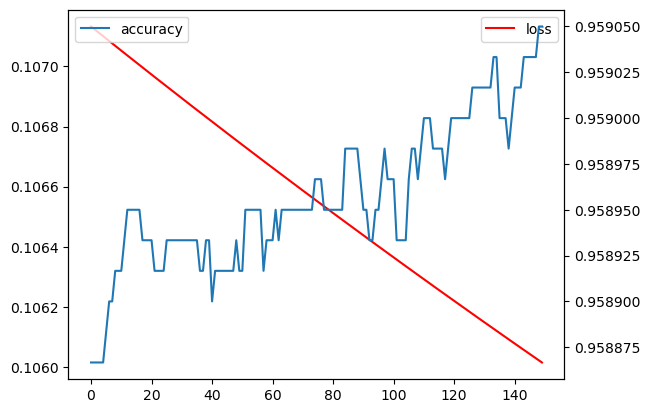

In [143]:
# 손실과 정확도 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(loss_accuracy[0], label = 'loss', color ='red')
ax2 = ax1.twinx()
ax2.plot(loss_accuracy[1], label = 'accuracy')

ax1.legend()
ax2.legend()
plt.xlabel('Epochs')
plt.show()
